# TTT4185 Machine learning for Speech technology

## Computer assignment 2: Classification using the Bayes Decision Rule and Support Vector Machines

This assignment assumes that the student has knowledge about the Bayes Decision Rule, maximum likelihood estimation and support vector machines.

In this assignment we will use `scikit-learn` (http://scikit-learn.org/stable/), which is a powerful and very popular Python toolkit for data analysis and machine learning, and `pandas` (https://pandas.pydata.org), which implements the all-powerful `DataFrame`.

We will also be using a small database of phonemes, where each phoneme is represented by the four first formant positions ("F1"-"F4") and their corresponding bandwidths ("B1"-"B4"). All numbers are in kHz. In addition, the speaker ID and the gender of the speaker are given for each phoneme.

### Problem 1

In this problem we will use the Bayes decision rule to classify vowels based on their formants. The formants have been extracted from the open database `VTR Formants database` (http://www.seas.ucla.edu/spapl/VTRFormants.html) created by Microsoft and UCLA.

(a) Download the files `Train.csv` and `Test.csv` from Blackboard, and load them into a `pandas` dataframe using the command `pd.read_csv`. Using the training data, create a single scatter plot of "F1" vs "F2" for the three vowels
- "ae" as in "bat"
- "ey" as in "bait"
- "ux" as in "boot"

Just eyeing the plots, discuss which classes will be hardest to classify correctly.

<IPython.core.display.Javascript object>


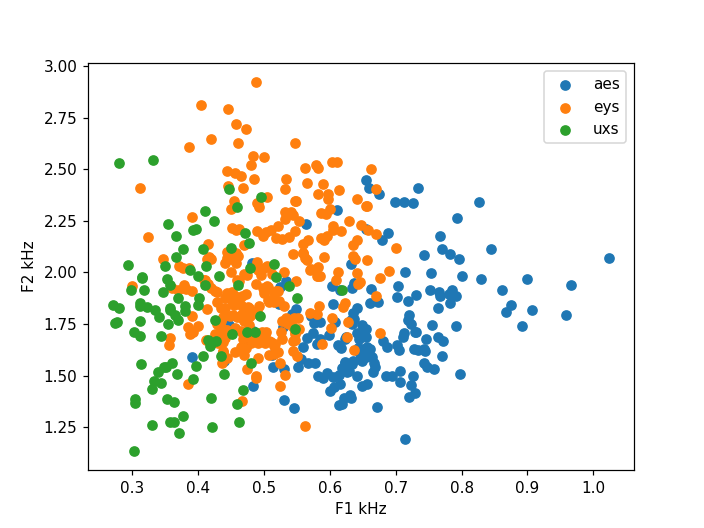

In [9]:
#!pip install pandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib notebook

# Load data
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

# Extract vowels
aes = train[train["Phoneme"] == 'ae']
eys = train[train["Phoneme"] == 'ey']
uxs = train[train["Phoneme"] == 'ux']

scatter = [aes, eys, uxs]
names = ['aes', 'eys', 'uxs']
# Plotting here
def F1vsF2ScatterPlot(plot_data, name):
    #name = [ k for k,v in locals().iteritems() if v == plot_data][0] #could use this instead of importing a name
    
    plt.xlabel('F1 kHz')
    plt.ylabel('F2 kHz')
    plt.scatter(plot_data['F1'],plot_data['F2'],label=name)
    #plt.legend(name)
    plt.legend()
    plt.show()

F1vsF2ScatterPlot(aes, 'aes')
F1vsF2ScatterPlot(eys, 'eys')
F1vsF2ScatterPlot(uxs, 'uxs')



The 'uxs' and the 'eys' could be difficult to classify, also the 'aes' and the 'eys' have a lot in common on the two first formants and therefor also be difficult to distinguish 

(b) Use the Bayes Decision Rule to create a classifier for the phonemes 'ae', 'ey' and 'ux' under the following constraints:
- The feature vector $x$ contains the first two formants, "F1" and "F2".
- The distribution of $x$ given a phoneme $c$, $P(x|c)$, is Gaussian.
- Use the maximum likelihood estimator to estimate the model parameters.

In [3]:
#!pip install scipy
import scipy.stats as ss 
#Things needed:
'''
    -Assuming all classes has the same covariance matrix
    -The mean of each class
    -covariance matrix

'''
def PreProcessing(training_data_set): #vowel you want from the training data, here it should only be ae,ea, ue
    #return train_data[train_data["Phoneme"] == vowel]
    models = []
    training_size = 0 
    for training_data in training_data_set:
        training_size += training_data.shape[0]
    for data in training_data_set:
        models.append({'mean': np.mean(data), 'cov': np.cov(data, rowvar=False), 'prior': data.shape[0]/training_size}) #this makes the Gaussian
    return models
    
    
    

def GaussianML(data):
    mean = np.mean(data)
    cov = np.cov(data, rowvar=False) #need to set rowvar to false since i dont want each row represents a variable, with observations in the columns
    return mean, cov

def Classifier(data, models): #this is seems to work now, but should be written much better, alot of unecessary computation i think
    num_classes = len(models)
    observations = len(data)
    prediction = []
    confusion_matrix = np.zeros((observations, num_classes))
    rvs = []
    priors = []
    
    for model in models:
        rvs.append(ss.multivariate_normal(mean=model['mean'], cov=model['cov']))
        priors.append(model['prior'])
    for i in range(len(data)):
        for j in range(len(data[i])):
            pred = []
            for model, rv in enumerate(rvs):
                pred.append(rv.pdf(data[i][j])*priors[model])
            prediction = np.argmax(pred)
            confusion_matrix[i][prediction] += 1
    return confusion_matrix
        
training_data =[aes[['F1','F2']],eys[['F1','F2']],uxs[['F1','F2']]]
aes_test = test[test["Phoneme"] == 'ae']
eys_test = test[test["Phoneme"] == 'ey']
uxs_test = test[test["Phoneme"] == 'ux']
testing_data =[aes_test[['F1','F2']].to_numpy(),eys_test[['F1','F2']].to_numpy(),uxs_test[['F1','F2']].to_numpy()]

models = PreProcessing(training_data)
#print(testing_data[0][0])
confusion_matrix = Classifier(testing_data, models)
print(confusion_matrix)
#predict(mean, cov)

def Classifier_alt(data, models): #this is not correct now, but a more compact version, could work
    num_classes = len(models)
    observations = len(data)
    confusion_matrix = np.zeros((observations, num_classes))
    predictions = []
    classes = []
    print(models)
    for i, model in enumerate(models):
        #print(f'i: {i}')
        #print(f'model: {model}')
        rvs = ss.multivariate_normal(mean=model['mean'], cov=model['cov'])
        predictions.append(rvs.pdf(data[i])*model['prior'])
        classes.append(model['class'])
        #print(predictions)
        #prediction = np.argmax(rvs.pdf(data[i])*model['prior'], axis=0)
        #print(f'prediciton {prediction}')
        #confusion_matrix[i,prediction] += 1
    predictions_prob = pd.DataFrame(predictions, columns=classes)
    
        
    return predictions_prob

    
    
    
    
    
    

[[80. 24.  1.]
 [13. 97.  4.]
 [ 1. 28. 23.]]


(c) To visualize the classes models and the classifier created in (b), plot the contours for each Gaussian distribution in the model, that is the class conditional likelihoods $P(x|c)$, by using the following function.

In [4]:
#import scipy.stats
#def plotGaussian(models, colors, ax):
def ScatterPlot(plot_data, name, ax, color):
    #name = [ k for k,v in locals().iteritems() if v == plot_data][0] #could use this instead of importing a name
    
    #ax.xlabel('F1 kHz')
    #ax.ylabel('F2 kHz')
    ax.scatter(plot_data['F1'],plot_data['F2'],label=name, color=color)
    #plt.legend(name)
    ax.legend()
    
    #plt.show()
    
def plotGaussian(mean, cov, color, ax):

    """ 
        Creates a contour plot for a bi-variate normal distribution
        
        mean: numpy array 2x1 with mean vector
        cov: numpy array 2x2 with covarince matrix
        color: name of color for the plot (see https://matplotlib.org/stable/gallery/color/named_colors.html)
        ax: axis handle where the plot is drawn (can for example be returned by plt.gca() or plt.subplots())
    """
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x, y = np.mgrid[xlim[0]:xlim[1]:(xlim[1]-xlim[0])/500.0, ylim[0]:ylim[1]:(ylim[1]-ylim[0])/500.0]
    xy = np.dstack((x, y))
    mvn = ss.multivariate_normal(mean, cov)
    lik = mvn.pdf(xy)
    ax.contour(x,y,lik,colors=color)
    plt.show()
#     for i, model in models:
#         mvn = scipy.stats.multivariate_normal(model['mean'], model['cov'])
#         lik = mvn.pdf(xy)
#         ax.contour(x,y,lik,colors=colors[i])
    

<IPython.core.display.Javascript object>


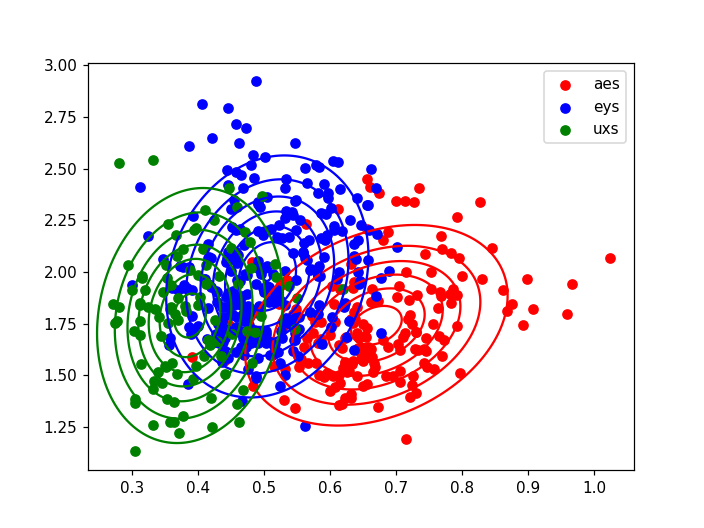

In [5]:
colors = ['r','b', 'g']
fig, ax = plt.subplots()
#Seems that I have to plot them in seperate loops so that the ax.get_()lim gets the limit of the entire plot. Doesnt look nice do



for idx, data in enumerate(scatter):
    ScatterPlot(data, names[idx], ax, colors[idx])

for i, model in enumerate(models):
    #ScatterPlot(scatter[i], names[i], ax, colors[i])
    plotGaussian(model['mean'], model['cov'],colors[i], ax)
 

*Try:* Plot the decision regions for the Bayesian classifier. Tips: Calculate the posterior for each class, use the `numpy.argmax` function to get the decision regions, and `matplotlib.pyplot.contourf` to plot them.

(d) Test your classifier on the 'ae', 'ey' and 'ux' phonemes from the test set and present your results in a _confusion matrix_, that is, a table where you see how many times 'ae' was correctly classified, how many times it was wrongly classified as 'ey' and so on.

<IPython.core.display.Javascript object>


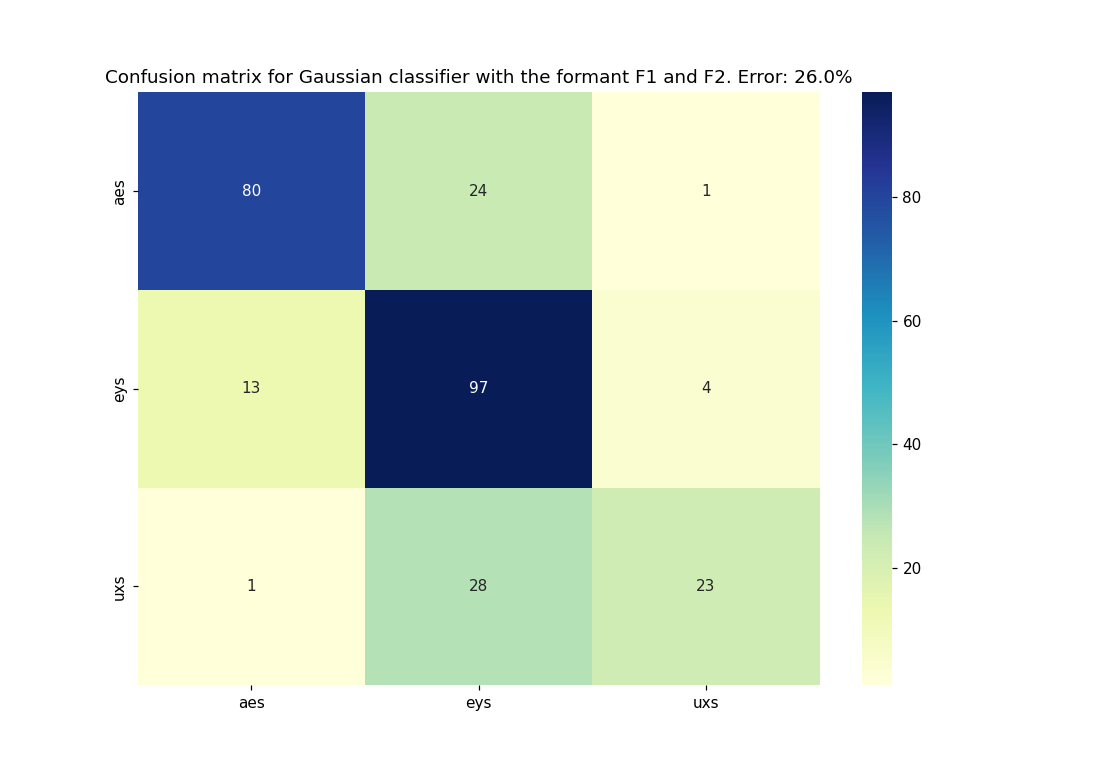

In [6]:
#!pip install seaborn
import seaborn as sn
def plot_confusion_matrix(data, class_names, title=''):
        dia_sum = 0
        for i in range(len(data)):
            dia_sum += data[i, i]
        error = 1 - dia_sum / np.sum(data)
        error = round(error,2)*100
        df_cm = pd.DataFrame(data, index = [i for i in class_names],
                  columns = [i for i in class_names])
        plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True, cmap="YlGnBu")
        plt.title(f'{title}. Error: {error}%')
        plt.show()
        #plt.clf()
        #plt.close()
class_names = ['aes','eys','uxs']
plot_confusion_matrix(confusion_matrix, class_names,title='Confusion matrix for Gaussian classifier with the formant F1 and F2')

(e) Extend your classifier to include the features "F1"-"F4" and compare the results with those in (d). Finally use all available information "F1"-"F4" and "B1-B4". How does the performance of this classifier compare with the simpler classifiers using fewer features?

This is for "F1"-"F4"

[[82. 21.  2.]
 [13. 98.  3.]
 [ 2. 25. 25.]]


<IPython.core.display.Javascript object>


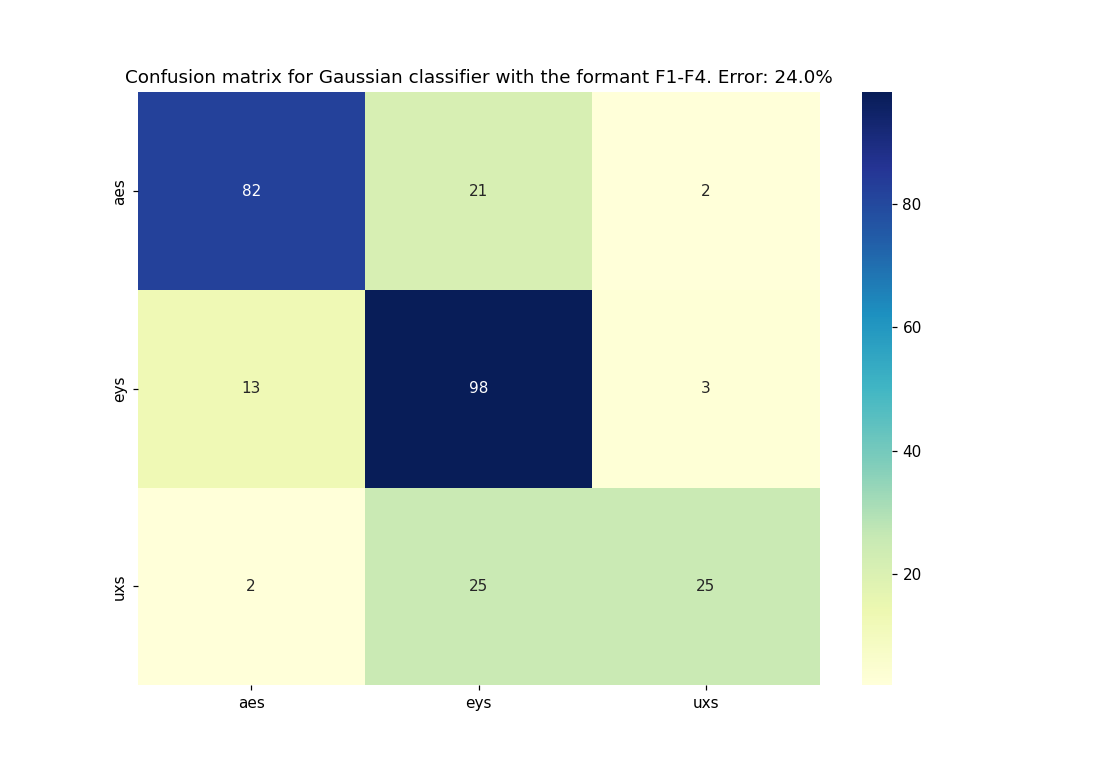

In [7]:

training_data_2 =[aes[['F1','F2','F3','F4']],eys[['F1','F2','F3','F4']],uxs[['F1','F2','F3','F4']]]

testing_data_2 =[aes_test[['F1','F2','F3','F4']].to_numpy(),eys_test[['F1','F2','F3','F4']].to_numpy(),uxs_test[['F1','F2','F3','F4']].to_numpy()]

models_2 = PreProcessing(training_data_2)
#print(testing_data[0][0])
confusion_matrix_2 = Classifier(testing_data_2, models_2)
print(confusion_matrix_2)
plot_confusion_matrix(confusion_matrix_2, class_names, title='Confusion matrix for Gaussian classifier with the formant F1-F4')

This is for all the data

[[82. 23.  0.]
 [13. 90. 11.]
 [ 3. 28. 21.]]


<IPython.core.display.Javascript object>


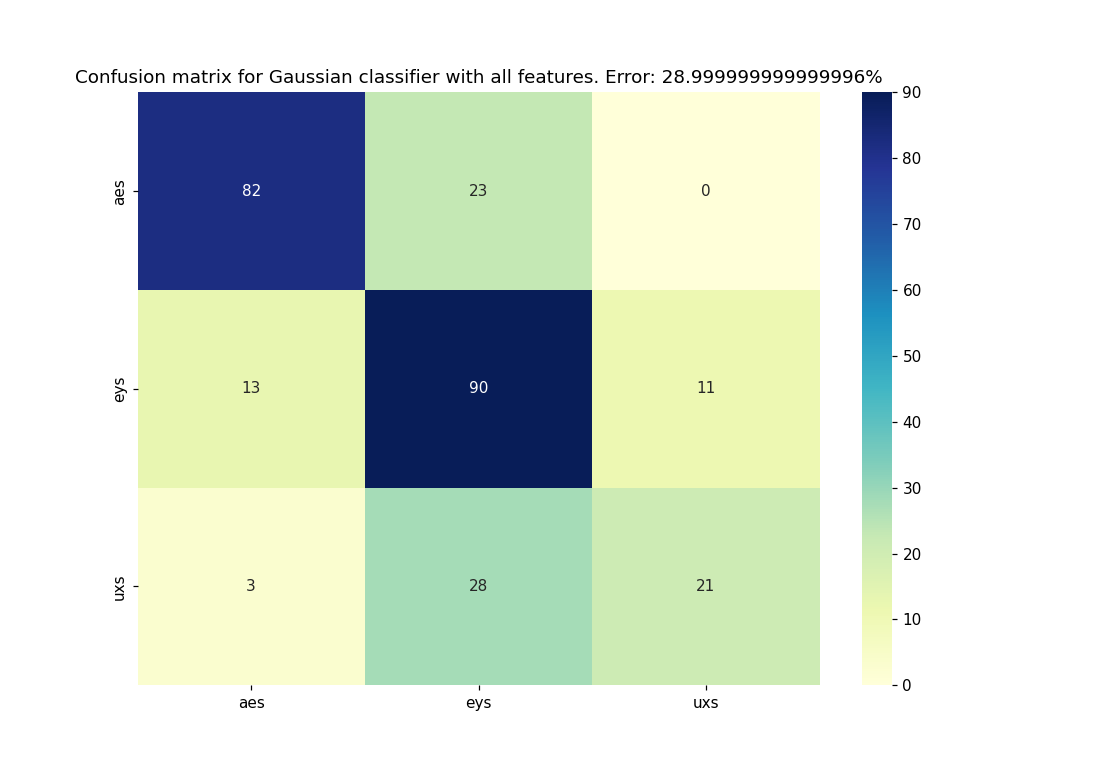

In [8]:
training_data_3 =[aes[['F1','F2','F3','F4','B1' ,'B2' ,'B3','B4']],eys[['F1','F2','F3','F4','B1' ,'B2' ,'B3','B4']],uxs[['F1','F2','F3','F4','B1' ,'B2' ,'B3','B4']]]

testing_data_3 =[aes_test[['F1','F2','F3','F4','B1' ,'B2' ,'B3','B4']].to_numpy(),eys_test[['F1','F2','F3','F4','B1' ,'B2' ,'B3','B4']].to_numpy(),uxs_test[['F1','F2','F3','F4','B1' ,'B2' ,'B3','B4']].to_numpy()]

models_3 = PreProcessing(training_data_3)
#print(testing_data[0][0])
confusion_matrix_3 = Classifier(testing_data_3, models_3)
print(confusion_matrix_3)
plot_confusion_matrix(confusion_matrix_3, class_names, title='Confusion matrix for Gaussian classifier with all features')

(f) We want to make the model slightly more powerful by modeling the feature vector conditional on both the vowel and gender of speaker, that is $P(x|g,c)$, where $g$ is the gender of the speaker and $c$ is the phoneme label. Show how these models can be used for phoneme classification using marginalization over the gender.

Assume that $P(x|g,c)$ is a multivariate Gaussian and compute the maximum likelihood estimates for the models. Compare the result on the test set with the results in (e).

In [29]:
'''
TODO:
    - split the dataset into the vowels with their respective gender. So we will have aes[Female] and aes[male] etc
    - make new priors with respect to the gender
    - when checking with the model, we sum the likelyhood of each gender per vowel and then take argmax
    
Possible solutions:
    - Using a 2d numpy array and use the preprossing with a doble for loop
    - Make a dictionary
    - try and use some pandas magic
'''
def PreProcessing_gender(training_data_set): #vowel you want from the training data, here it should only be ae,ea, ue
    #return train_data[train_data["Phoneme"] == vowel]
    models = [[]]
    training_size = 0 
    for training_data in training_data_set:
        training_size += training_data.shape[0]
    for data in training_data_set:
        models.append({'mean': np.mean(data), 'cov': np.cov(data, rowvar=False), 'prior': data.shape[0]/training_size, 'gender': data['Gender']}) #this makes the Gaussian
    return models
    

def Classifier_gender(data, models): #this is seems to work now, but should be written much better, alot of unecessary computation i think
    num_classes = len(models)
    observations = len(data)
    prediction = []
    confusion_matrix = np.zeros((observations, num_classes))
    rvs = []
    priors = []
    
    for model in models:
        rvs.append(ss.multivariate_normal(mean=model['mean'], cov=model['cov']))
        priors.append(model['prior'])
    for i in range(len(data)):
        for j in range(len(data[i])):
            pred = []
            for model, rv in enumerate(rvs):
                pred.append(rv.pdf(data[i][j])*priors[model])
            prediction = np.argmax(pred)
            confusion_matrix[i][prediction] += 1
    return confusion_matrix

#this works but are really ugly, will fix up later just checking if it works and what i need to do

aes_f = aes[aes["Gender"] == 'F']
aes_m = aes[aes["Gender"] == 'M']
eys_f = eys[eys["Gender"] == 'F']
eys_m = eys[eys["Gender"] == 'M']
uxs_f = uxs[uxs["Gender"] == 'F']
uxs_m = uxs[uxs["Gender"] == 'M']

#training_set4 = [[aes_f[['F1','F2','F3','F4','B1' ,'B2' ,'B3','B4']],aes_m[['F1','F2','F3','F4','B1' ,'B2' ,'B3','B4']]], [eys_f[['F1','F2','F3','F4','B1' ,'B2' ,'B3','B4']],eys_m[['F1','F2','F3','F4','B1' ,'B2' ,'B3','B4']]], [uxs_f[['F1','F2','F3','F4','B1' ,'B2' ,'B3','B4']],uxs_m[['F1','F2','F3','F4','B1' ,'B2' ,'B3','B4']]]]
training_set4 = np.array([[aes_f,aes_m], [eys_f,eys_m], [uxs_f,uxs_m]])
#print(aes_f['Gender'].values[0])
print(training_set4.shape[1])
#print(training_set4[0][0])

2


C:\Users\vegar\AppData\Local\Temp/ipykernel_29776/1923877958.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_set4 = np.array([[aes_f,aes_m], [eys_f,eys_m], [uxs_f,uxs_m]])


(g) When using Gaussian classifiers we often avoid computing the entire covariance matrix, but instead we only use the diagonal of the matrix. Repeat the results in (f) using only diagonal covariance matrices and compare the results.

### Problem 2

In this problem we use the support vector machine (SVM) to build classifiers. We use the same dataset as in Problem 1. It is up to you to select which features to use.

We use the function `sklearn.svm.SVC` from `scikit-learn` in this problem. First you need to get your data on the format that `SVC` expects, which is a matrix where every row is a feature vector, and a list of integer labels corresponding to each row. We suggest using "ae" = 0, "ey" = 1 and "ux" = 2.

An example on how to use the `SVC` is given in http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC. In short, we do the following (for a linear kernel):
- Instantiate an SVC object: `cls = SVC(kernel='linear')`
- Train the SVM using the feature vector matrix `train_X`, and label vector `train_Y`: `cls.fit(train_X, train_Y)`
- Predict labels on the test set `Test_X` using: `cls.predict(Test_X)`

You can use or adapt the following functions to visualize the SVM decision regions and support vectors in 2D.

In [ ]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

def Plot_SVM_decision_regions(clf,data,labels):
    '''
    This function is for plotting the decision area of SVM
    
    Args:
    - clf: SVM model
    - data: Data with two features
    - labels: Corresponding labels of the data
    '''
    phonemes = np.array(["ae","ey","ux"])
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(phonemes)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = label_encoder.transform(Z)
    Z = Z.reshape(xx.shape)
    #Plotting
    plt.figure(figsize=(10,6))
    sns.scatterplot(data[:,0],data[:,1],hue=labels)
    plt.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    plt.legend()
    plt.title('Decision Area of SVM')
    plt.show()

def Plot_Support_Vectors(clf,data):
    '''
    This function is for plotting the support vectors of the SVM model
    
    Args:
    - clf: SVM model
    - data: Data with two features
    '''
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = label_encoder.transform(Z)
    Z = Z.reshape(xx.shape)
    #Plotting
    plt.figure(figsize=(10,6))
    plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c='k',alpha=0.4,label='support vector')
    plt.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    plt.legend()
    plt.title('Support Vectors')
    plt.show()

(a) Create a linear SVM with different penalty terms $C=\{0.1, 1, 10\}$ and compare with the results in Problem 1.

(b) Try different kernels ('rbf', 'poly', 'sigmoid') and compare the results. Choose one of the kernels and use different penalty terms $C$. What happens with the performance on the training set when you increase $C$? What happens with the performance on the test set?